This task uses GREG Bigbin as database.
At first, we still need to start neo4j/GREG, if you don't know how to do it, please refer to [my workshop2 about graph Algorithms](https://nbviewer.jupyter.org/github/xiaowei3223/GREGgraphAlgorithms/blob/master/workshop2/GREG_Algorithms.ipynb) to learn for start neo4j/GREG.

[1. Number of nodes of each type (TF, chr1, etc)](#1)

[2. Number of relationships of each type (bind, etc)](#2)

[3. List of hubs for chr12 (a hub is a node with a high degree)](#3)

[4. Degree distribution for chr12 (GREG-min)](#4)

[5. Modules for chromosome 12](#5)

[6. Annotate all modules with the genes they contain in their bins](#6)

[7. save all results as RData](#7)

Now, we use `RNeo4j` package to get all the results of the task.

In [1]:
#connect neo4j with RNeo4j
library(RNeo4j)

graph = startGraph("http://localhost:7474/db/data/", username="neo4j", password="xiaowei")

<h1 id='1'>1. Number of nodes of each type (TF, chr1, etc)<h1>

In [2]:
query = "MATCH (n) RETURN distinct labels(n) as label, count(labels(n)) as count"

labels <- cypher(graph,query) 

In [3]:
labels

label,count
<chr>,<int>
chr1,1245
chr2,1211
chr3,992
chr4,951
chr5,908
chr6,854
chr7,797
chr8,726
chr9,692


In [4]:
write.csv(labels, file = "labels.csv", sep=",",quote = F, col.names = TRUE, row.names = FALSE)

Warning message in write.csv(labels, file = "labels.csv", sep = ",", quote = F, :
"attempt to set 'col.names' ignored"Warning message in write.csv(labels, file = "labels.csv", sep = ",", quote = F, :
"attempt to set 'sep' ignored"

To get `labels.csv` at [here](labels.csv).

<h1 id='2'>2. Number of relationships of each type (bind, etc)<h1>

In [5]:
query = "MATCH ()-[r]->() RETURN type(r) as relationshipType, count(*) as count;"

relationshipType <- RNeo4j::cypher(graph,query)

In [6]:
relationshipType

relationshipType,count
<chr>,<int>
Bind,2372086
Interaction,1781980
Inclusion,1322494


<h1 id='3'>3. List of hubs for chr12 (a hub is a node with a high degree)<h1>

chr12 nodes have Bind and Interaction relationships. 

At the first, we use cypher command `'MATCH (n:chr12)-[r]-(m) with {m,n} as chr12_And_rel'` for the first argument of `algo.degree.stream`; then we will difine a subgraph with all relationships during all nodes including chr12 and nodes directerly related to chr12.

After using degree algorithm, we need to filter all chr12 nodes by `MATCH (chr12:chr12) where chr12.Name = chr12_And_rel` and to remove those 0 degree score of chr12. 

At the end, we return back chr12 nodes names and its degree score. 

In [7]:
query = "
CALL algo.degree.stream(
  'MATCH (n:chr12)-[r]-(m) with {m,n} as chr12_And_rel',
  'Bind | Interaction',
  {direction: 'both'})
YIELD nodeId, score
with algo.asNode(nodeId).Name AS chr12_And_rel, score
MATCH (chr12:chr12)
where chr12.Name = chr12_And_rel and score > 0
RETURN chr12.Name AS Name, score as degree
ORDER By score DESC
"
chr12_hubs <- cypher(graph, query)

In [8]:
head(chr12_hubs)

Name,degree
<chr>,<dbl>
Bin314,780
Bin321,700
Bin175,697
Bin344,687
Bin247,678
Bin428,674


In [9]:
dim(chr12_hubs)

[1] 12167     2

In [10]:
write.table(chr12_hubs, file = "chr12_hubs.csv",sep=",",quote = F, col.names = TRUE, row.names = FALSE)

To get chr12_hubs.csv at [here](chr12_hubs.csv)

<h1 id='4'>4. Degree distribution for chr12 <h1>

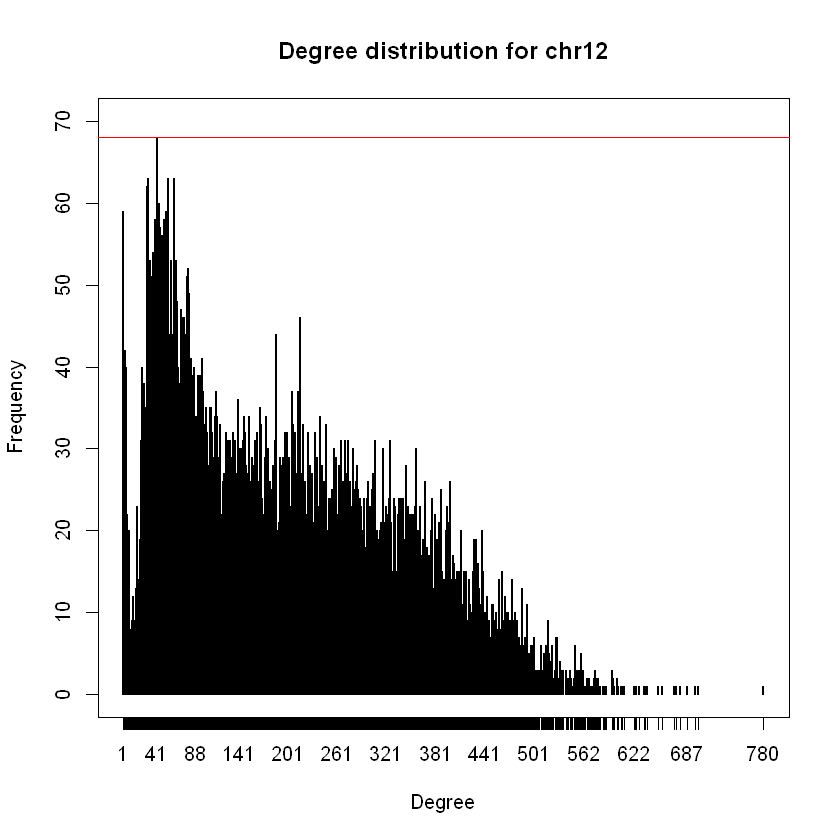

In [11]:
distribution <- table(chr12_hubs$degree)
plot(distribution,
     #xlim = c(0,500),
     ylim = c(0,70),
     xlab = "Degree", 
     ylab = "Frequency",
     main = "Degree distribution for chr12")

abline(h=max(distribution), col="red")

In [12]:
max(distribution)

[1] 68

In [13]:
distribution[distribution ==68]

42 
68

In [14]:
median(distribution)

[1] 20

As you see, the max frequency of chr12_hubs is 68, and its degree is 42.

<h1 id='5'>5. Modules for chromosome 12<h1>

In [15]:
# To know the numbers of modules ----------------
query = "CALL algo.louvain(
          'MATCH (n:chr12)-[r]-(m) with {m,n} as chr12_And_rel',
          'Bind | Interaction',
          {direction: 'both'})
        YIELD nodes, communityCount"
cypher(graph, query)  #Results： nodes:1288086 communityCount:23929

nodes,communityCount
<int>,<int>
1288086,23929


At here analysis, you need to know 1288086 nodes including all chr12 nodes and all nodes directly related chr12 nodes.

##### Then we filter all nodes are chr12 in their community as following:

In [16]:
query = "
CALL algo.louvain.stream(
          'MATCH (n:chr12)-[r]-(m) with {m,n} as chr12_And_rel',
          'Bind | Interaction',
          {direction: 'both'})
YIELD nodeId, community
with algo.asNode(nodeId) AS　chr12_And_rel, community
MATCH (chr12:chr12)
where chr12.Name = chr12_And_rel.Name
RETURN collect( chr12.Name )  AS Name, community
ORDER BY size(Name) DESC
"
module_chr12_total = cypher(graph, query) 

In [17]:
module_chr12_total[1:2,]

Name                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [18]:
dim(module_chr12_total)

[1] 1171    2

<h1 id='6'>6. Annotate all modules with the genes they contain in their bins<h1>

Before we run to get genes, we should learn string function `split()` and `substring()`.

Example is a chr12 node, we use `split()` to get a list of details property of this node.   

`split()` returns a list of strings resulting from the splitting of the original string around matches of the given delimiter.

Syntax: `split(original, splitDelimiter)`

In [19]:
query = "MATCH( chr12:chr12{Name: 'Bin20'})
RETURN split(chr12.Details, ';') as Details"
cypher(graph,query)

Details
<list>
"3791047 , 3873448 , gene_id ENSG00000111224.13 , gene_type protein_coding , gene_name PARP11 , level 2 , havana_gene OTTHUMG00000156442.5, |3839459 , 3842525 , gene_id ENSG00000118976.5 , gene_type processed_pseudogene , gene_name HIN1L , level 1 , tag pseudo_consens , havana_gene OTTHUMG00000168119.1, |3871734 , 3910338 , gene_id ENSG00000256862.1 , gene_type antisense , gene_name RP11-664D1.1 , level 2 , havana_gene OTTHUMG00000168120.1,"


In order to you can easy to see that this result is list; we use `UNWIND` to  transform this list back into individual rows.

In [20]:
query = "MATCH( chr12:chr12{Name: 'Bin20'})
with split(chr12.Details, ';') as Details
UNWIND Details AS details
RETURN details
"
cypher(graph,query)

details
<chr>
3791047
3873448
gene_id ENSG00000111224.13
gene_type protein_coding
gene_name PARP11
level 2
havana_gene OTTHUMG00000156442.5
|3839459
3842525


Now, we use `substring()` to get gene names. In Details property, gene names always use `gene_name ` for tell use what its genes contained in this nodes.

`substring()` returns a substring of the original string, beginning with a 0-based index start and length.

Syntax: `substring(original, start [, length])`

In [21]:
query = "MATCH( chr12:chr12{Name: 'Bin20'})
with split(chr12.Details, ';') as Details
UNWIND Details AS details
with details as details
where details contains 'gene_name'
with details as genes
return substring(genes,11) as genes
"
cypher(graph,query)

genes
<chr>
PARP11
HIN1L
RP11-664D1.1


So, the node chr12 `Bin200` includes 3 genes.

###### Now, we can use that functions to do our tasks.

In [22]:
query = "
// to make louvain modules for chr12
CALL algo.louvain.stream(
          'MATCH (n:chr12)-[r]-(m) with {m,n} as chr12_And_rel',
          'Bind | Interaction',
          {direction: 'both'})
YIELD nodeId, community
with algo.asNode(nodeId).Details AS　Details, community

// split details
with split(Details, ';') as ann, community

// then ann is list, we need unlist ann for strings search
UNWIND (ann) as ann1
with  ann1 as ann1, community

// now we want to find out which one terms including gene_name in ann1
where ann1 contains 'gene_name'
with ann1 as genelist, community +1 as community

// And we can extract the text about real gene names
return distinct substring(genelist, 11) as genelist, 'module' + community as community
"

module_chr12 = cypher(graph, query) 

In [23]:
head(module_chr12)

genelist,community
<chr>,<chr>
DDX11L1,module1
WASH7P,module1
MIR6859-1,module1
RP11-34P13.3,module1
MIR1302-2,module1
FAM138A,module1


In [24]:
dim(module_chr12)

[1] 58511     2

In [25]:
write.table(module_chr12, file = "module_chr12.csv" ,sep=",",quote = F, col.names = TRUE, row.names = FALSE)

To get `module_chr12.csv` at [here](module_chr12.csv)

Or we process the results showing as list of modules with R.

In [26]:
module_genelist <- aggregate(module_chr12[1], by = module_chr12[2], FUN = as.character)
module_genelist <- as.list(module_genelist$genelist)
names(module_genelist) <- paste("module",1:length(module_genelist))

In [27]:
query = "
// to make louvain modules for chr12
CALL algo.louvain.stream(
          'MATCH (n:chr12)-[r]-(m) with {m,n} as chr12_And_rel',
          'Bind | Interaction',
          {direction: 'both'})
YIELD nodeId, community
with algo.asNode(nodeId).Details AS　Details, community

// filter the number of community(Details) > 1 and split details
//where size(Details) > 1 
with split(Details, ';') as ann, community

// then ann is list, we need unlist ann for strings search
UNWIND (ann) as ann1
with DISTINCT ann1 as ann1, community

// now we want to find out which one terms including gene_name in ann1
where ann1 contains 'gene_name'
with ann1 as genelist, community +1 as community

// And we can extract the text about real gene names
return collect( distinct substring(genelist, 11) ) as genelist, 'module' + community as community
"

module_chr12_list = RNeo4j::cypher(graph, query)

<h1 id='7'>7. save all the results<h1>

To get all results at [here](allResults.Rdata).

In [28]:
save(labels,relationshipType,chr12_hubs,distribution,module_chr12,module_genelist,module_chr12_list,
     file = "allResults.Rdata")